# Predicting Carbon Emissions in Rwanda

#### Importing Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

pd.set_option('mode.chained_assignment', None)

#### Importing Datasets

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#### Data Exploration

In [7]:
display(df_train.head())

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [3]:
df_train.shape

(79023, 76)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [26]:
# Selecting a subset of features that may have an impact on carbon emissions for in-depth exploratory data analysis.
df_filtered = df_train[['ID_LAT_LON_YEAR_WEEK', 
                        'latitude', 
                        'longitude', 
                        'year', 
                        'week_no', 
                        'SulphurDioxide_SO2_column_number_density', 
                        'CarbonMonoxide_CO_column_number_density',
                        'CarbonMonoxide_H2O_column_number_density', 
                        'NitrogenDioxide_NO2_column_number_density',  
                        'Formaldehyde_tropospheric_HCHO_column_number_density', 
                        'UvAerosolIndex_absorbing_aerosol_index', 
                        'Ozone_O3_column_number_density', 
                        'Cloud_cloud_fraction', 
                        'emission']]

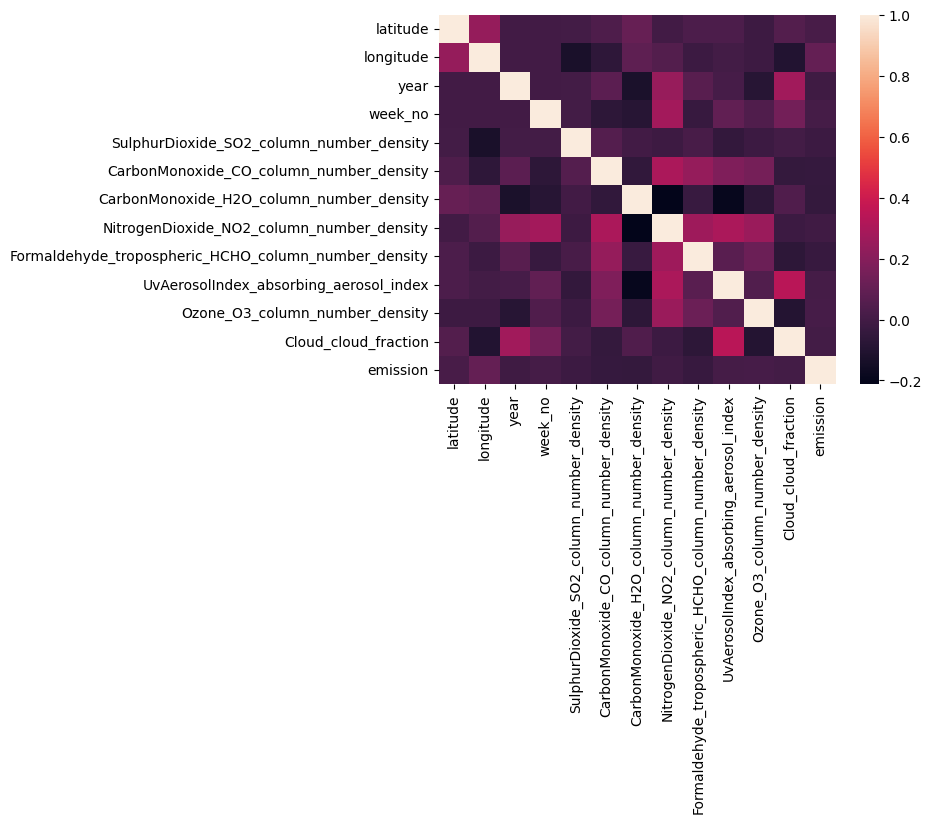

In [13]:
# Plotting Correlation Matrix
corr_matrix = df_filtered.corr(numeric_only=True)
sn.heatmap(corr_matrix)
plt.show()

At a glance, there appears to be very little correlation between carbon emissions and any other types of emissions

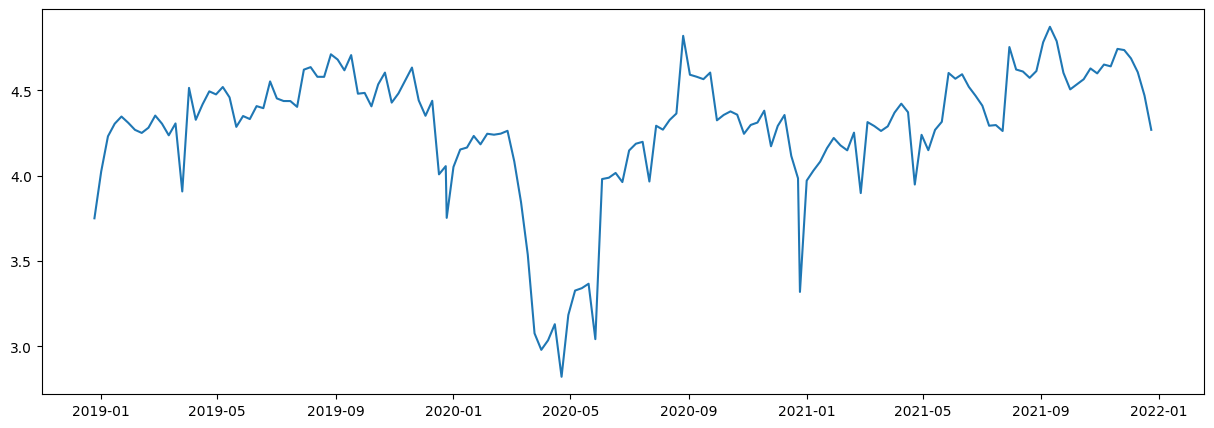

In [36]:
# Adding dates
def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)

df_filtered['date'] =  df_filtered.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

# Getting unique pairs for longitude and latitude
unique_lon_lats = df_filtered[['longitude', 
                               'latitude']].drop_duplicates()

# First test location
long = unique_lon_lats.iloc[0, 0]
lat = unique_lon_lats.iloc[0, 1]

df_one_location = df_filtered.query("longitude == @long and latitude == @lat")

# Ploting emissions over time
plt.figure(figsize = (15, 5))
plt.plot(df_one_location['date'], df_one_location['emission'])
plt.show()

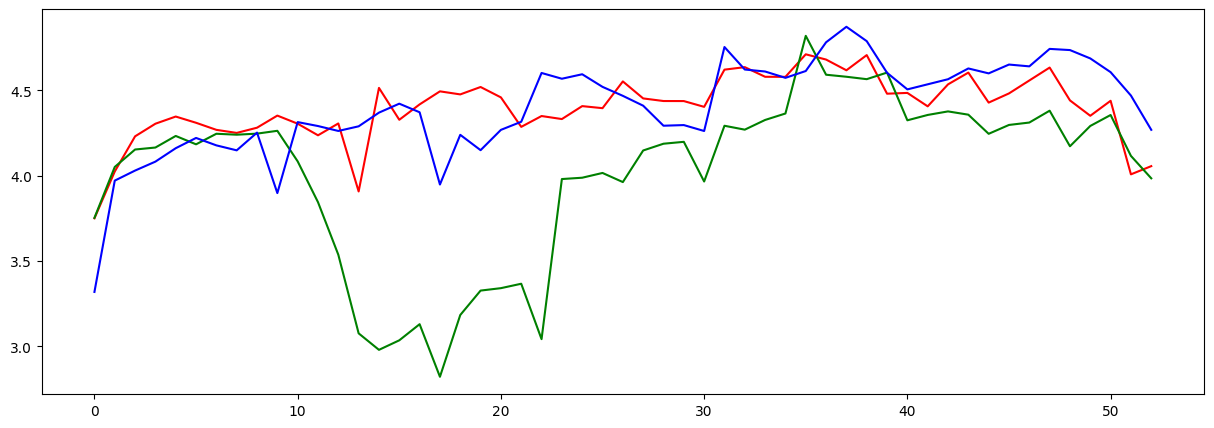

In [39]:
# Plotting emissions over week_no
df_2019 = df_one_location.query("year == 2019")
df_2020 = df_one_location.query("year == 2020")
df_2021 = df_one_location.query("year == 2021")

plt.figure(figsize = (15, 5))
plt.plot(df_2019['week_no'], df_2019['emission'], color = 'red')
plt.plot(df_2020['week_no'], df_2020['emission'], color = 'green')
plt.plot(df_2021['week_no'], df_2021['emission'], color = 'blue')
plt.show()

Excluding mid 2020, carbon emissions seem to follow an annual pattern.